## Skin Lesion Classification
### W207 Final Group Project
#### Suyash Dusad, Pavel Golukhin, Tyler Ryu, Radhika Satapathy

### <span style="color:blue">1. Import Python libraries

In [1]:
# Import required python libraries

import time
import copy
import csv
import glob
import cv2
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as sk

from matplotlib.legend_handler import HandlerLine2D
from matplotlib.ticker import MultipleLocator

from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.ndimage import gaussian_filter
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss

from PIL import Image
from cv2 import *
from scipy import ndarray
from skimage import transform
from skimage import util
from operator import itemgetter

# Set the randomizer seed so results are the same each time.
np.random.seed(123)

pd.set_option('display.float_format', '{:.2f}'.format)

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

### <span style="color:blue">2. Load Image Data 

In [2]:
# Specify path to where jpeg images are stored
path = glob.glob(r"../HAM10000_images/*.jpg")

# create an empty array to hold image data
data = []

# create an empty array to hold image ids
image_id= []

# Use cv2 to read in jpeg images into a numpy array of pixel values
for f1 in path:
    img = cv2.imread(f1)
    img = cv2.resize(img,(28,28))
    data.append(np.array(np.array(img).ravel()))
    image_id.append(f1[f1.find('ISIC'):-4])
    
# Scale image data pixel values to range from (0-1)
image_data=np.array(data)/255
print(len(image_data))

# Add image_ids to pixel data
images_data_with_id=pd.DataFrame(image_data,image_id)
images_data_with_id.reset_index(level=0, inplace=True)
images_data_with_id.rename(columns ={'index':'image_id'}, inplace = True)

# Loading meta data info into a pandas df from the csv
metadata_df = pd.read_csv(r'../Data/HAM10000_metadata.csv')
print(len(metadata_df))

# Adding columns to denote classification names and labels
metadata_df['lesion_type'] = 'x'
metadata_df['label'] = 0

# Create dictionaries that would help associate the 3 letter abbr. code with lesion types and numeric encodings
# will be useful later

lesion_types = {
                'akiec':'Actinic keratoses',
                'bcc':'Basal cell carcinoma', 
                'bkl':'Benign keratosis-like lesions', 
                'df':'Dermatofibroma', 
                'nv':'Melanocytic nevi', 
                'vasc':'Vascular lesions', 
                'mel':'Melanoma'                
               }

label_codes = {
                0:'Actinic keratoses',
                1:'Basal cell carcinoma', 
                2:'Benign keratosis-like lesions', 
                3:'Dermatofibroma', 
                4:'Melanocytic nevi', 
                5:'Vascular lesions', 
                6:'Melanoma'                
               }

labels = {
            0:'akiec',
            1:'bcc', 
            2:'bkl', 
            3:'df', 
            4:'nv', 
            5:'vasc', 
            6:'mel'                
           }

# update lesion_type with full form 
for key, value in lesion_types.items():
    metadata_df['lesion_type'].loc[metadata_df['dx'] == key] = value    

# update label with numeric encoding
for key, value in labels.items():
    metadata_df['label'].loc[metadata_df['dx'] == value] = key      
      
# create a merged df of pixel data alongwith metadata
overall_data = pd.merge(metadata_df,images_data_with_id,on='image_id')

# create numpy arrays of just pixel data(X) and labels(Y)
X=np.array(overall_data.drop(['lesion_id','image_id','dx','dx_type','lesion_type','age','sex','localization', 'label'],axis=1))
Y=np.array(overall_data['dx'])

10015
10015


C:\Users\RadLaptop\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### <span style="color:blue">3. EDA (Exploratory Data Analysis)


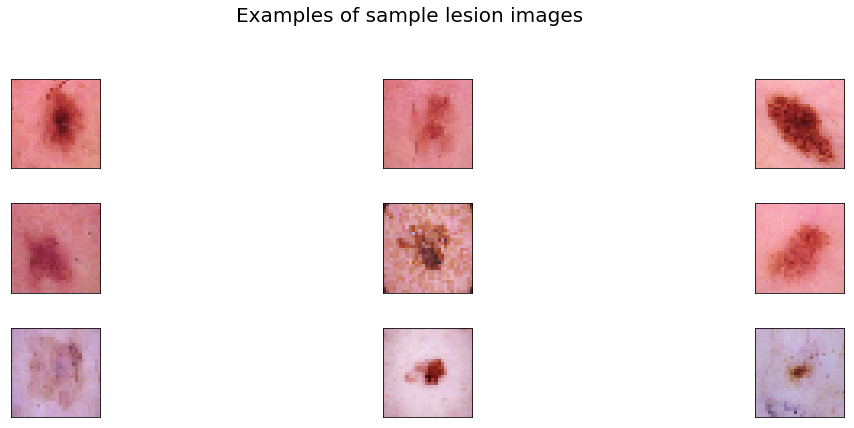

In [3]:
# 3-1 Visualize samples

# Display a given number of samples
def display_img(data,num_examples=0):
    
    #setting the area for the plots of all images
    plt.figure(figsize=(20,20))
    
    #running a loop for each data point in new_data
    for i in range(num_examples):
        
        #setting the title for the plots
        plt.suptitle("Examples of sample lesion images",fontsize=20,y=0.93)
        
        #identifying number of sub plots needed based on the number of examples requested as input 
        plt.subplot(num_examples,3,i+1)
        
        #formatting the plots
        plt.xticks([])
        plt.yticks([])
        plt.subplots_adjust(wspace=0, hspace=0.4)
        plt.grid(False)
        
        #reshaping the data into a (28,28,3) grid to plot the data and plotting all the data points
        plt.imshow(cv2.cvtColor(data[i].reshape((28, 28,3)), cv2.COLOR_BGR2RGB))
    
    plt.show() 

display_img(data,9)



Cumulative counts of images of the various lesion types:

Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: lesion_type, dtype: int64


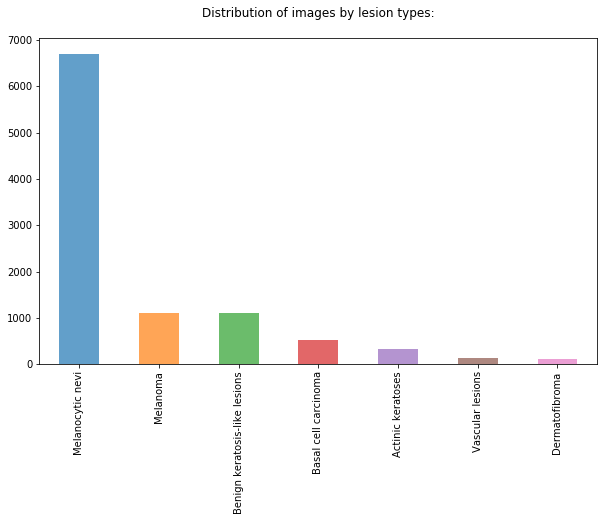

In [4]:
# 3-2 Study distribution of classes across lesion types

vc = overall_data["lesion_type"].value_counts()

print("Cumulative counts of images of the various lesion types:\n")
print(vc)

vc.plot(kind='bar',stacked=True, figsize=(10,6), alpha=0.7, title="Distribution of images by lesion types:\n")
plt.show()


#### <span style="color:blue">Insight 1:

The above plot reveals that the data is greatly imbalanced with the number of benign lesions overpowering the numbers of other types. For instance, confirmed melanoma samples constitute only 17% of the overall samples. This may call for data to be balanced prior to using it to train an ML model to avoid bias in results.

Research revealed that there are many ways to balance data, oversampling the minority class and undersampling the majority class being the two primary options, which avoid the need for gathering more labeled samples prior to training.


Cumulative counts of images of the various lesion types by validation technology:

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64


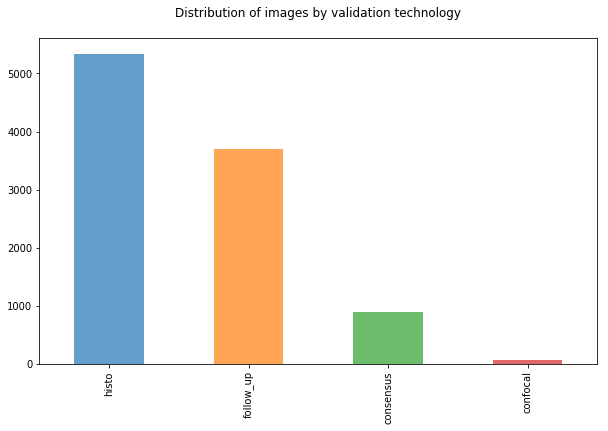

In [5]:
# 3-3 Distribution of lesion samples by validation technology

vc = overall_data["dx_type"].value_counts()

print("Cumulative counts of images of the various lesion types by validation technology:\n")
print(vc)

vc.plot(kind='bar',stacked=True, figsize=(10,6), alpha=0.7, title="Distribution of images by validation technology\n")
plt.show()


Cumulative counts of images by localization and lesion types:

abdomen            1022
acral                 7
back               2192
chest               407
ear                  56
face                745
foot                319
genital              48
hand                 90
lower extremity    2077
neck                168
scalp               128
trunk              1404
unknown             234
upper extremity    1118
Name: localization, dtype: int64


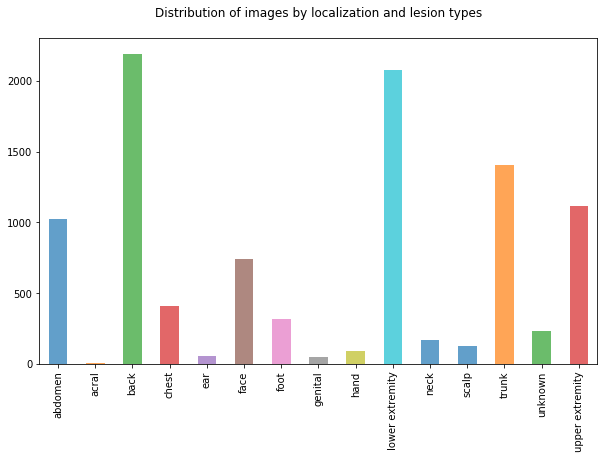

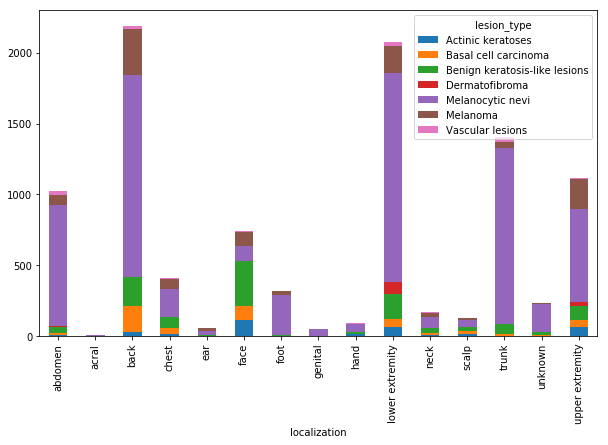

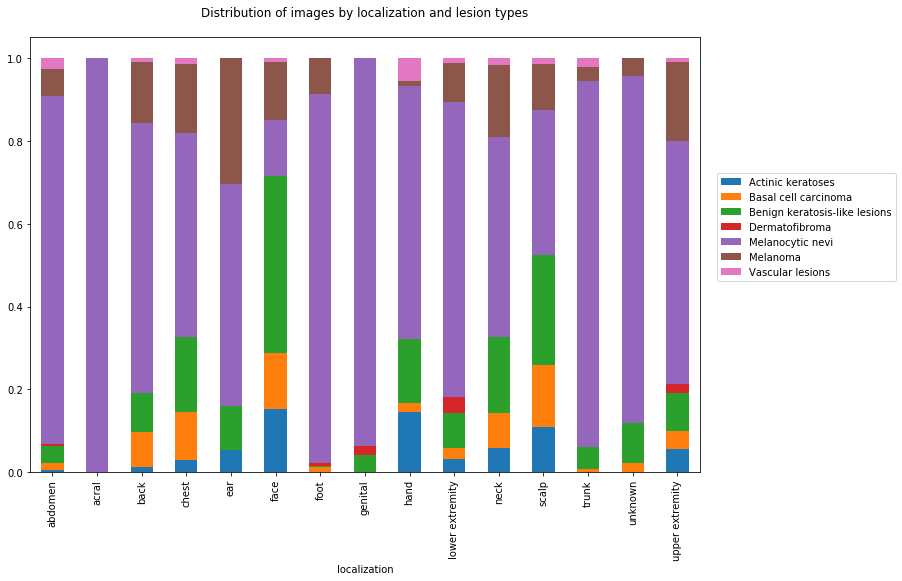

In [3]:
# 3-4 Distribution of lesion samples by localization (i.e. place on the body where they occur)

vc = overall_data["localization"].value_counts().sort_index()

print("Cumulative counts of images by localization and lesion types:\n")
print(vc)

vc.plot(kind='bar',stacked=True, figsize=(10,6), alpha=0.7, title="Distribution of images by localization and lesion types\n")
plt.show()


# 3-4 Plot histogram by localization by localization and lesion_type
overall_data.groupby(['localization', 'lesion_type']).size().reset_index().pivot(columns='lesion_type', index='localization', values=0).plot(kind='bar',figsize=(10,6), stacked=True)
plt.show()

# 3-4 100% stacked bar chart for distribution by gender
df_pct = (overall_data.groupby(['localization', 'lesion_type'])['dx'].count()/overall_data.groupby(['localization'])['dx'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(12,8), title="Distribution of images by localization and lesion types\n" )
plt.legend(bbox_to_anchor=(1.3,0.7), loc="upper right")

#### <span style="color:blue">Insight 2: 
From the charts above we can see that certain body parts such as foot genital only have Melanocytic nevi lesions. It should be noted that we have lesion data for Melanoma and Melanocytic nevi lesions for almost all localizations. Also certain lesion types are mostly seen in certain localizations. For ex: Basal cell carcinoma (caused by sun burns) is mostly seen in back, chest, scalp, neck and and face - areas exposed to the sun and in tanning stations.

Cumulative counts of images by gender:

male       5406
female     4552
unknown      57
Name: sex, dtype: int64


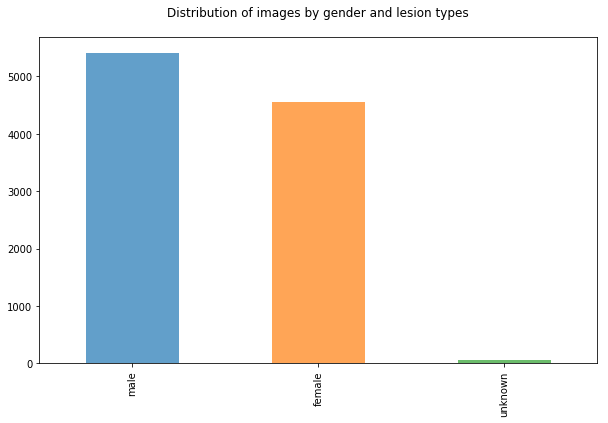

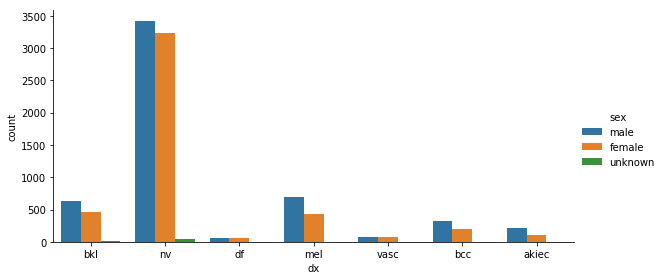

In [7]:
# 3-5 Distribution of lesion samples by gender

vc = overall_data["sex"].value_counts()

print("Cumulative counts of images by gender:\n")
print(vc)

vc.plot(kind='bar',stacked=True, figsize=(10,6), alpha=0.7, title="Distribution of images by gender and lesion types\n")
plt.show()


sns.catplot(x="dx", hue="sex",kind='count', data=overall_data, height=4, aspect=8/4)
plt.show()

#### <span style="color:blue">Insight 3:
It can be seen that almost all lesion types are evenly distributed across gender.It also confirms that there isn't any lesion type which is specific to a certain gender.

Cumulative counts of images by age and lesion types:

0.00       39
5.00       86
10.00      41
15.00      77
20.00     169
25.00     247
30.00     464
35.00     753
40.00     985
45.00    1299
50.00    1187
55.00    1009
60.00     803
65.00     731
70.00     756
75.00     618
80.00     404
85.00     290
Name: age, dtype: int64


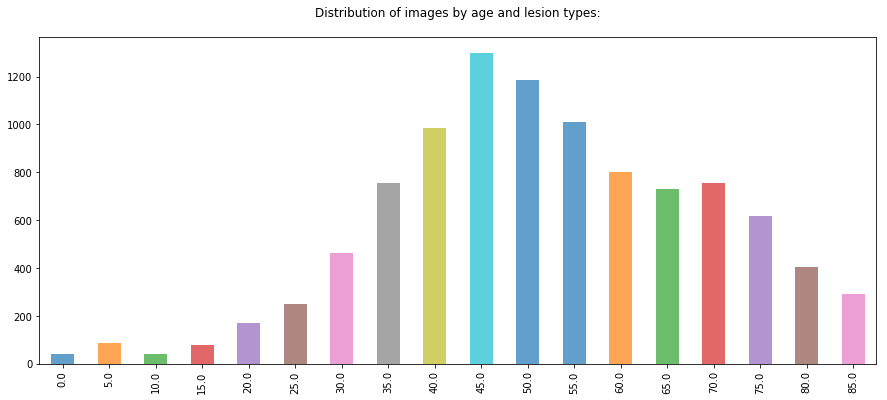

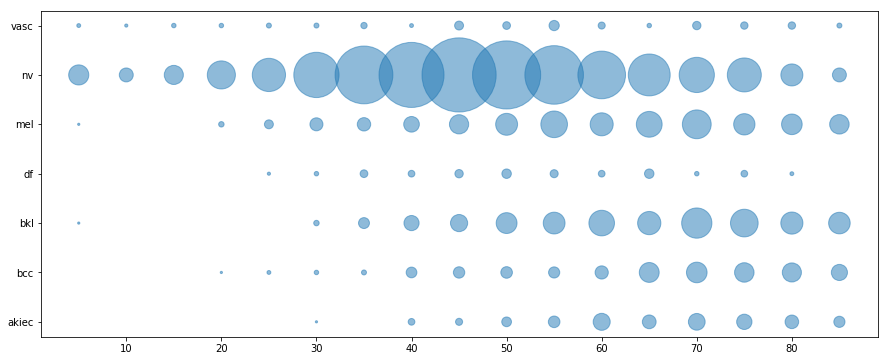

In [8]:
# 3-6 Distribution of lesion samples by age

vc = overall_data["age"].value_counts().sort_index()

print("Cumulative counts of images by age and lesion types:\n")
print(vc)

vc.plot(kind='bar',stacked=True, figsize=(15,6), alpha=0.7, title="Distribution of images by age and lesion types:\n")
plt.show()

# Plot lesion_type against age
plt.figure(figsize=(15,6))
xyz = overall_data.groupby(["dx", "age"]).size().reset_index(name="total")
x = xyz.loc[xyz['age'] >0].age
y = xyz.loc[xyz['age'] >0].dx
z = xyz.loc[xyz['age'] >0].total
plt.scatter(x, y, z*5, alpha=0.5, )
plt.show()

#### <span style="color:blue">Insight 4:
    
The distribution reveals that most images were of lesions belonging to individuals from the 45-50 age group category. Further, a majority of lesions across all age categories are that of benign melanocytic moles. The cancareous lesion images seem to mostly belong to the 55-70 age category. 


4501
4501


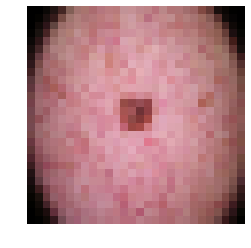

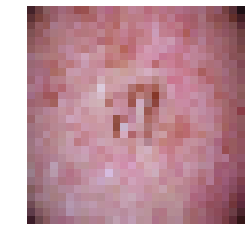

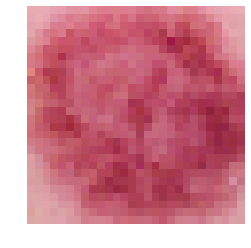

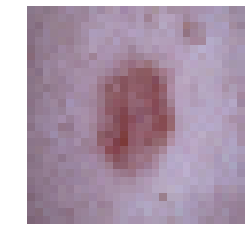

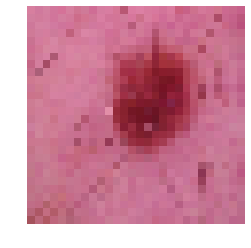

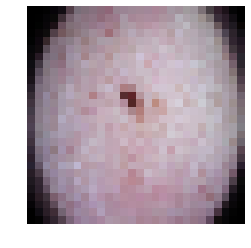

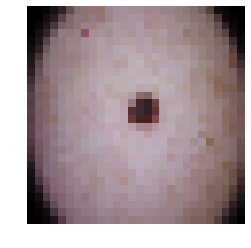

In [12]:
# Check for duplicates of images

my_list = pd.concat(g for _, g in overall_data.groupby("lesion_id") if len(g) >= 2)
indx_list = list(my_list.index.values)

multi_img_X = np.array(data)[indx_list]
print(len(multi_img_X))

multi_img_Y = Y[indx_list]
print(len(multi_img_Y))

# Display some image pairs
for num in range(0,7):
    plt.imshow(cv2.cvtColor(multi_img_X[num].reshape((28, 28,3)), cv2.COLOR_BGR2RGB), cmap=plt.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()


#### <span style="color:blue">Insight 5: 
    
There were a few lesion samples with multiple images taken at different zooms. We thought of initially removing them from the data set for training however later convened that they might be useful in helping us assess whether the magnification scale of the image impacted accuracy of classification. i.e. would an image of a lesion taken at X magnification be classified any more correctly or incorrectly by our trained classifier.


### <span style="color:blue">4. Prepare data for ML </span>
(data cleaning, transformations, pre-processing, feature scaling, test-train splitting)

In [8]:
# SPLIT DATA

# Set the randomizer seed so results are the same each time.
np.random.seed(123)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print("Data Shape :", X.shape)
print("Label Shape :", Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[8000:], Y[8000:]
dev_data, dev_labels = X[7000:8000], Y[7000:8000]
train_data, train_labels = X[:7000], Y[:7000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
    

Data Shape : (10015, 2352)
Label Shape : (10015,)


In [14]:
# ASSESS SAMPLING BIAS i.e. whether the training and test subsets are representative of the overall sample set

print("\nSAMPLE BIAS ANALYSIS")
print("\nLesion Type\tOriginal\tTrain\t\tTest\t\tDev\t\tMini_Train")
for key, value in lesion_types.items():
    indx = np.where(Y==key)
    indx_train = np.where(train_labels==key)
    indx_test = np.where(test_labels==key)
    indx_dev = np.where(dev_labels==key)
    indx_mini_train = np.where(mini_train_labels==key)
    print(key, ":\t\t", round(len(X[indx])*100/len(X),2), "\t\t", 
          round(len(train_data[indx_train])*100/len(train_data),2), "\t\t", 
          round(len(test_data[indx_test])*100/len(test_data),2), "\t\t",
          round(len(dev_data[indx_dev])*100/len(dev_data),2), "\t\t",
          round(len(mini_train_data[indx_mini_train])*100/len(mini_train_data),2)
         )


SAMPLE BIAS ANALYSIS

Lesion Type	Original	Train		Test		Dev		Mini_Train
akiec :		 3.27 		 3.3 		 3.08 		 3.4 		 3.0
bcc :		 5.13 		 5.24 		 5.16 		 4.3 		 5.2
bkl :		 10.97 		 11.1 		 10.22 		 11.6 		 9.7
df :		 1.15 		 1.11 		 1.19 		 1.3 		 0.9
nv :		 66.95 		 66.74 		 67.59 		 67.1 		 67.9
vasc :		 1.42 		 1.46 		 1.29 		 1.4 		 1.4
mel :		 11.11 		 11.04 		 11.46 		 10.9 		 11.9


### <span style="color:blue">5. Generate Base Models</span>


In [9]:
# Define functions needed for models

def model_type(model,X_train,Y_train,X_test,Y_test):
    """
    This function trains the specified model with the specified training data, 
    uses the trained model to predict using the specified test set,
    and prints a classification report of the model
    """
    
    # Produce a model
    clf = model

    # Train the model using training data
    clf.fit(X_train,Y_train)

    # Predict using testing data
    predicted = clf.predict(X_test)
    
    # Evaluate overall accuracy of model
    accuracy = clf.score(X_test, Y_test)
    print("\nOverall Accuracy:", accuracy)

    # Generate classification report
    print("\nClassification Report:\n")
    print(classification_report(Y_test, predicted))
    
    #INCLUDE CODE FOR PRINTING IMAGES OF SAMPLES MOST CONFUSED HERE, IF NEEDED
    
       

def binarize_pixels(data, thresholds=0.5):
    """  
    This function takes a data set and applies a threshold (based on the 
    the third values of the range of min/max values of the elements) to convert
    continuous pixel values into one of 3 discrete values.
    """ 
       
    # Initialize a new array with the same shape as the original data.
    bin_data = np.zeros(data.shape)

    # Iterate through images and apply thresholds to each pixel value of the image
    for img in range(data.shape[0]):

        for feature in range(data.shape[1]):          

            if data.item((img,feature)) < thresholds:
                bin_data.itemset((img,feature),0) # pixel value < 0.5 categorized as white
            else:
                bin_data.itemset((img,feature),1)
    return bin_data



def discretize_pixels(data, thresholds=[0,0]):
    """  
    This function takes a data set and applies a threshold (based on the 
    the third values of the range of min/max values of the elements) to convert
    continuous pixel values into one of 3 discrete values.
    """ 
    if thresholds == [0,0]    :
        thresholds=np.around([(np.amax(data) - np.amin(data))/3, (np.amax(data) - np.amin(data))*2/3], decimals=1)    
    #print("\nThreshold Values:", thresholds)

    # Initialize a new array with the same shape as the original data.
    multi_data = np.zeros(data.shape)

    # Iterate through images and apply thresholds to each pixel value of the image
    for img in range(data.shape[0]):

        for feature in range(data.shape[1]):          

            if data.item((img,feature)) < thresholds[0]:
                multi_data.itemset((img,feature),0) # pixel value < 0.3 categorized as white

            elif data.item((img,feature)) > thresholds[1]:
                multi_data.itemset((img,feature),2) # pixel value > 0.7 categorized as gray

            else:
                multi_data.itemset((img,feature),1)
    return multi_data


#### Running base models

In [10]:
# Define function for running all models


def models(X_train,X_train_labels,X_test,X_test_labels):
    """
    This function converts the train and test data sets to the appropriate input representation 
    required by the various ML models and invokes the functions to execute the models with the 
    transformed data
    """
    
    #run Knn model
    print('Results for knn model:')
    print('-'*100)
    model_type(KNeighborsClassifier(n_neighbors=1),X_train,X_train_labels,X_test,X_test_labels)
    print('-'*100)
    
    #run BNB model
    # Binarize input data
    bin_X_train = binarize_pixels(X_train,)
    bin_X_test = binarize_pixels(X_test,)
    print('Results for BNB model:')
    print('-'*100)
    model_type(BernoulliNB(),bin_X_train,X_train_labels,bin_X_test,X_test_labels)
    print('-'*100)
    
    #run MNB model
    multi_X_train = discretize_pixels(X_train,)
    multi_X_test = discretize_pixels(X_test,)
    print('Results for MNB model:')
    print('-'*100)
    model_type(MultinomialNB(),multi_X_train,X_train_labels,multi_X_test,X_test_labels)
    print('-'*100)
    
    #run Gaussian NB model
    print('Results for Gaussian NB model:')
    print('-'*100)
    model_type(GaussianNB(),X_train,X_train_labels,X_test,X_test_labels)
    print('-'*100)
    
    #run Logistic regression model
    print('Results for Logistic Regression model:')
    print('-'*100)
    model_type(LogisticRegression(),X_train,X_train_labels,X_test,X_test_labels)
    print('-'*100)
    
    #run SVM model
    print('Results for SVM model:')
    print('-'*100)
    model_type(SVC(),X_train,X_train_labels,X_test,X_test_labels)
    
    
    
models(train_data,train_labels,test_data,test_labels)

Results for knn model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.678908188585608

Classification Report:

              precision    recall  f1-score   support

       akiec       0.44      0.23      0.30        62
         bcc       0.38      0.31      0.34       104
         bkl       0.35      0.35      0.35       206
          df       0.09      0.08      0.09        24
         mel       0.35      0.16      0.22       231
          nv       0.79      0.89      0.83      1362
        vasc       0.14      0.19      0.16        26

    accuracy                           0.68      2015
   macro avg       0.36      0.31      0.33      2015
weighted avg       0.64      0.68      0.65      2015

----------------------------------------------------------------------------------------------------
Results for BNB model:
---------------------------------------------------------------------------------------------

C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Overall Accuracy: 0.7017369727047147

Classification Report:

              precision    recall  f1-score   support

       akiec       0.32      0.11      0.17        62
         bcc       0.49      0.35      0.40       104
         bkl       0.39      0.26      0.31       206
          df       1.00      0.08      0.15        24
         mel       0.31      0.13      0.18       231
          nv       0.76      0.94      0.84      1362
        vasc       0.64      0.27      0.38        26

    accuracy                           0.70      2015
   macro avg       0.56      0.31      0.35      2015
weighted avg       0.65      0.70      0.66      2015

----------------------------------------------------------------------------------------------------
Results for SVM model:
----------------------------------------------------------------------------------------------------


C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Overall Accuracy: 0.6759305210918114

Classification Report:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        62
         bcc       0.00      0.00      0.00       104
         bkl       0.00      0.00      0.00       206
          df       0.00      0.00      0.00        24
         mel       0.00      0.00      0.00       231
          nv       0.68      1.00      0.81      1362
        vasc       0.00      0.00      0.00        26

    accuracy                           0.68      2015
   macro avg       0.10      0.14      0.12      2015
weighted avg       0.46      0.68      0.55      2015



C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Confusion Matrix and Samples Confused

C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Confusion Matrix:

[[   7   11    9    0    4   30    1]
 [   2   36   16    0    5   45    0]
 [   3    4   54    0   22  122    1]
 [   2    7    1    2    1   11    0]
 [   6    5   19    0   30  171    0]
 [   2    9   37    0   34 1278    2]
 [   0    2    1    0    1   15    7]]


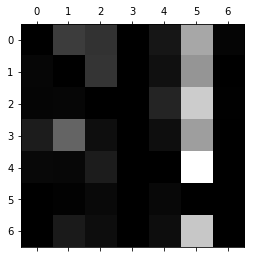


Lesions most confused are: Melanocytic nevis with Vascular lesionss



In [17]:
# Code for printing confusion matrix and confused samples 


# Prep code

# Produce a model
clf = LogisticRegression()

# Train the model using training data
clf.fit(train_data,train_labels)

# Predict using testing data
predicted = clf.predict(test_data)


# -----------Actual code begins here: plug this into model_type as needed  ----------------------  
    
# Generate confusion matrix
print("\nConfusion Matrix:\n")
conf_mx = confusion_matrix(test_labels, predicted)
print(conf_mx)

# Normalize confusion matrix numbers to reflect error_rates as opposed to #errors 
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0) #Replace diagonal elements to zero to obtain a matrix of just error rates

# Plot normalized confusion matrix
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) 
plt.show()

# Locate images most often confused/ misclassified ->(max. error rate)
result = np.where(norm_conf_mx == np.amax(norm_conf_mx))
coords_list = list(zip(result[0], result[1]))
for coord in coords_list:
    (d1,d2) = coord
    print("\nLesions most confused are: "+ label_codes[d1] + "s with " 
          + label_codes[d2] +"s\n")
 


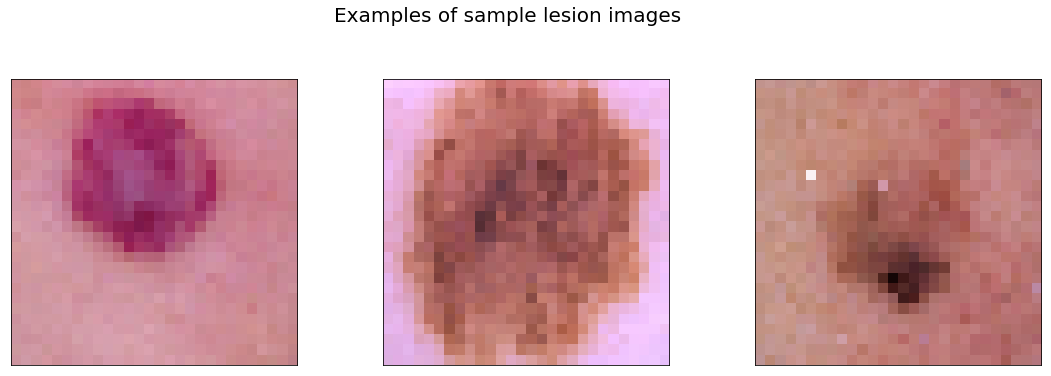

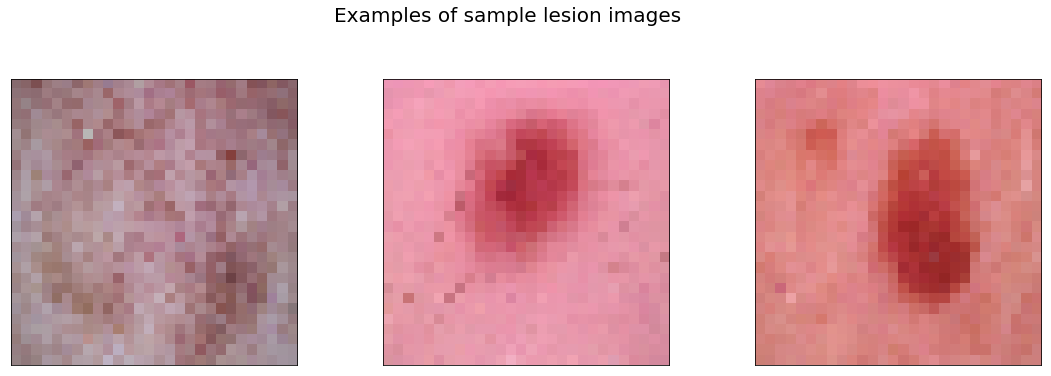

In [18]:
# Display 3 samples each of the confused lesion types
   
image_df = overall_data.loc[overall_data['label'] == d1]
indx_list = list(image_df.index.values)
image_arr = np.array(data)[indx_list]
display_img(image_arr,3)

    
image_df = overall_data.loc[overall_data['label'] == d2]
indx_list = list(image_df.index.values)
image_arr = np.array(data)[indx_list]
display_img(image_arr,3)
    

### <span style="color:blue">6. Pre-processing Techniques</span>

#### 6-1 Dimensionality Reduction using PCA

Explained Variance	# PCA Components

0.8 			 10 

0.87 			 20 

0.91 			 50 

0.93 			 75 

0.94 			 100 

0.96 			 200 

0.97 			 300 

0.98 			 400 

0.98 			 500 



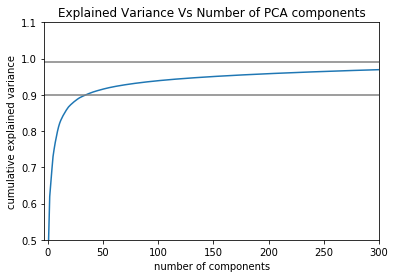

In [19]:
# Find best value for n_components at 90% and 99% total explained variance

start_time=time.time()

# Define data to be reduced
X_train = train_data
X_test = dev_data

print("Explained Variance\t# PCA Components\n" )

for n in [10, 20, 50, 75, 100, 200, 300, 400, 500]:
    
    # Project data 
    pca = PCA(n_components=n)
    X_train_proj = pca.fit_transform(X_train)
    X_test_proj = pca.transform(X_test)
   
    # Evaluate explained_variance
    info_retained = sum(pca.explained_variance_ratio_)
    
    print(round(info_retained,2),"\t\t\t", n,'\n')
   
    
# Plot explained variance Vs number of PCA components 
plt.xlim([-3, 300])
plt.ylim([0.5, 1.1])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(0.99, color="gray")
plt.axhline(0.90, color="gray")
plt.title("Explained Variance Vs Number of PCA components", fontsize=12)
plt.show()

In [20]:
# Code for re-running models with best PCA values

# Define PCA values for 90% & 99% explained variance
pca_values = [50, 500] 

for n in pca_values:
    
    #Scaling
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train_data)
    scaled_test = scaler.transform(test_data)

    print("Accuracy when data is reduced to", n, "principal components:")   
    
    # Project scaled data for n pca components
    pca = PCA(n_components=n)
    X_train_proj = pca.fit_transform(scaled_train)
    X_test_proj = pca.transform(scaled_test)
    models(X_train_proj,train_labels,X_test_proj,test_labels)
    

Accuracy when data is reduced to 50 principal components:
Results for knn model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.6774193548387096

Classification Report:

              precision    recall  f1-score   support

       akiec       0.42      0.31      0.36        62
         bcc       0.37      0.35      0.36       104
         bkl       0.35      0.36      0.36       206
          df       0.00      0.00      0.00        24
         mel       0.37      0.26      0.30       231
          nv       0.81      0.86      0.84      1362
        vasc       0.15      0.23      0.18        26

    accuracy                           0.68      2015
   macro avg       0.35      0.34      0.34      2015
weighted avg       0.66      0.68      0.67      2015

----------------------------------------------------------------------------------------------------
Results for BNB model:
----------------------------------

C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\suydu\Anaconda3\lib\site-packages\s


Overall Accuracy: 0.6972704714640199

Classification Report:

              precision    recall  f1-score   support

       akiec       0.33      0.06      0.11        62
         bcc       0.44      0.27      0.34       104
         bkl       0.45      0.29      0.35       206
          df       0.00      0.00      0.00        24
         mel       0.41      0.09      0.15       231
          nv       0.74      0.95      0.83      1362
        vasc       0.36      0.15      0.22        26

    accuracy                           0.70      2015
   macro avg       0.39      0.26      0.28      2015
weighted avg       0.63      0.70      0.64      2015

----------------------------------------------------------------------------------------------------
Results for SVM model:
----------------------------------------------------------------------------------------------------


C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avo


Overall Accuracy: 0.6759305210918114

Classification Report:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        62
         bcc       0.00      0.00      0.00       104
         bkl       0.00      0.00      0.00       206
          df       0.00      0.00      0.00        24
         mel       0.00      0.00      0.00       231
          nv       0.68      1.00      0.81      1362
        vasc       0.00      0.00      0.00        26

    accuracy                           0.68      2015
   macro avg       0.10      0.14      0.12      2015
weighted avg       0.46      0.68      0.55      2015



C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy when data is reduced to 500 principal components:
Results for knn model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.6704714640198511

Classification Report:

              precision    recall  f1-score   support

       akiec       0.33      0.18      0.23        62
         bcc       0.32      0.28      0.30       104
         bkl       0.32      0.33      0.33       206
          df       0.06      0.04      0.05        24
         mel       0.37      0.19      0.26       231
          nv       0.79      0.88      0.83      1362
        vasc       0.14      0.19      0.16        26

    accuracy                           0.67      2015
   macro avg       0.33      0.30      0.31      2015
weighted avg       0.64      0.67      0.65      2015

----------------------------------------------------------------------------------------------------
Results for BNB model:
---------------------------------

C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Overall Accuracy: 0.6183622828784119

Classification Report:

              precision    recall  f1-score   support

       akiec       0.11      0.24      0.15        62
         bcc       0.36      0.09      0.14       104
         bkl       0.16      0.11      0.13       206
          df       0.08      0.04      0.06        24
         mel       0.36      0.38      0.37       231
          nv       0.77      0.81      0.79      1362
        vasc       0.50      0.12      0.19        26

    accuracy                           0.62      2015
   macro avg       0.33      0.26      0.26      2015
weighted avg       0.60      0.62      0.60      2015

----------------------------------------------------------------------------------------------------
Results for Logistic Regression model:
----------------------------------------------------------------------------------------------------


C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Overall Accuracy: 0.678908188585608

Classification Report:

              precision    recall  f1-score   support

       akiec       0.16      0.13      0.14        62
         bcc       0.32      0.26      0.29       104
         bkl       0.34      0.22      0.27       206
          df       0.07      0.04      0.05        24
         mel       0.34      0.16      0.22       231
          nv       0.77      0.91      0.84      1362
        vasc       0.53      0.31      0.39        26

    accuracy                           0.68      2015
   macro avg       0.36      0.29      0.31      2015
weighted avg       0.62      0.68      0.64      2015

----------------------------------------------------------------------------------------------------
Results for SVM model:
----------------------------------------------------------------------------------------------------


C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Overall Accuracy: 0.6972704714640199

Classification Report:

              precision    recall  f1-score   support

       akiec       0.40      0.06      0.11        62
         bcc       0.39      0.20      0.27       104
         bkl       0.41      0.24      0.30       206
          df       0.00      0.00      0.00        24
         mel       0.40      0.03      0.06       231
          nv       0.73      0.97      0.83      1362
        vasc       0.00      0.00      0.00        26

    accuracy                           0.70      2015
   macro avg       0.33      0.22      0.23      2015
weighted avg       0.61      0.70      0.62      2015



C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 6-2 Balancing classes /data

In [21]:
# Code for re-running models with balanced data (oversampled)

start_time=time.time()

# Step1: Scale data to reflect zero mean and unit variance
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Step 2: Reduce data to primary components (pca=50)
pca = PCA(n_components=50)
X_train_proj = pca.fit_transform(scaled_train)
X_test_proj = pca.transform(scaled_test)

# Step3: Balance minority classes by oversampling with SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=7)
for i in range(0, 6):
    otrain_data, otrain_labels = sm.fit_sample(X_train_proj, train_labels)
    X_train_proj, train_labels = otrain_data, otrain_labels
    
# Step 4: Run models with balanced data
models(otrain_data,otrain_labels,X_test_proj,test_labels)


Results for knn model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.6084367245657568

Classification Report:

              precision    recall  f1-score   support

       akiec       0.28      0.39      0.33        62
         bcc       0.30      0.38      0.33       104
         bkl       0.31      0.44      0.37       206
          df       0.02      0.04      0.03        24
         mel       0.31      0.36      0.33       231
          nv       0.89      0.72      0.79      1362
        vasc       0.10      0.31      0.15        26

    accuracy                           0.61      2015
   macro avg       0.32      0.38      0.33      2015
weighted avg       0.69      0.61      0.64      2015

----------------------------------------------------------------------------------------------------
Results for BNB model:
--------------------------------------------------------------------------------------------

C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Overall Accuracy: 0.38213399503722084

Classification Report:

              precision    recall  f1-score   support

       akiec       0.16      0.26      0.20        62
         bcc       0.17      0.30      0.22       104
         bkl       0.19      0.18      0.19       206
          df       0.02      0.25      0.04        24
         mel       0.27      0.63      0.37       231
          nv       0.91      0.39      0.54      1362
        vasc       0.05      0.35      0.09        26

    accuracy                           0.38      2015
   macro avg       0.25      0.34      0.24      2015
weighted avg       0.68      0.38      0.45      2015

----------------------------------------------------------------------------------------------------
Results for Logistic Regression model:
----------------------------------------------------------------------------------------------------


C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Overall Accuracy: 0.5047146401985112

Classification Report:

              precision    recall  f1-score   support

       akiec       0.13      0.34      0.19        62
         bcc       0.22      0.38      0.28       104
         bkl       0.35      0.38      0.36       206
          df       0.11      0.46      0.17        24
         mel       0.27      0.49      0.35       231
          nv       0.93      0.54      0.68      1362
        vasc       0.13      0.69      0.22        26

    accuracy                           0.50      2015
   macro avg       0.31      0.47      0.32      2015
weighted avg       0.71      0.50      0.56      2015

----------------------------------------------------------------------------------------------------
Results for SVM model:
----------------------------------------------------------------------------------------------------


C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Overall Accuracy: 0.6784119106699752

Classification Report:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        62
         bcc       0.50      0.01      0.02       104
         bkl       0.83      0.02      0.05       206
          df       0.00      0.00      0.00        24
         mel       0.00      0.00      0.00       231
          nv       0.68      1.00      0.81      1362
        vasc       0.00      0.00      0.00        26

    accuracy                           0.68      2015
   macro avg       0.29      0.15      0.12      2015
weighted avg       0.57      0.68      0.55      2015



C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
# Code for re-running models with balanced data (undersampled)

# Run this block if running soon after the experiment with SMOTE
# to reset values of traing labels correctly
# START

# Set the randomizer seed so results are the same each time.
np.random.seed(123)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print("Data Shape :", X.shape)
print("Label Shape :", Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[8000:], Y[8000:]
dev_data, dev_labels = X[7000:8000], Y[7000:8000]
train_data, train_labels = X[:7000], Y[:7000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

# END



#-----Actual code for this experiment begins here-----

# Code for re-running models with balanced data (undersampled)

start_time=time.time()

# Step1: Scale data to reflect zero mean and unit variance
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Step 2: Reduce data to primary components (pca=50)
pca = PCA(n_components=50)
X_train_proj = pca.fit_transform(scaled_train)
X_test_proj = pca.transform(scaled_test)

# Step3: Balance minority classes by undersampling with NearMiss
nm = NearMiss()
otrain_data, otrain_labels = nm.fit_sample(X_train_proj, train_labels)
    
# Step 3: Run models with balanced data
models(otrain_data,otrain_labels,X_test_proj,test_labels)

Data Shape : (10015, 2352)
Label Shape : (10015,)
Results for knn model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.2729528535980149

Classification Report:

              precision    recall  f1-score   support

       akiec       0.12      0.22      0.15        77
         bcc       0.18      0.24      0.21        99
         bkl       0.20      0.20      0.20       253
          df       0.01      0.17      0.02        24
         mel       0.25      0.32      0.28       240
          nv       0.84      0.28      0.43      1298
        vasc       0.02      0.42      0.04        24

    accuracy                           0.27      2015
   macro avg       0.23      0.26      0.19      2015
weighted avg       0.61      0.27      0.35      2015

----------------------------------------------------------------------------------------------------
Results for BNB model:
------------------------------------------

C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\suydu\Anaconda3\lib\site-packages\s


Overall Accuracy: 0.19702233250620346

Classification Report:

              precision    recall  f1-score   support

       akiec       0.16      0.32      0.22        77
         bcc       0.45      0.23      0.31        99
         bkl       0.55      0.10      0.17       253
          df       0.01      0.38      0.02        24
         mel       0.21      0.23      0.22       240
          nv       0.85      0.19      0.31      1298
        vasc       0.08      0.54      0.13        24

    accuracy                           0.20      2015
   macro avg       0.33      0.28      0.20      2015
weighted avg       0.67      0.20      0.27      2015

----------------------------------------------------------------------------------------------------
Results for Logistic Regression model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.254590570719603

Classification Report:

              precision    recall  f

C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Overall Accuracy: 0.04466501240694789

Classification Report:

              precision    recall  f1-score   support

       akiec       0.31      0.06      0.11        77
         bcc       0.35      0.06      0.10        99
         bkl       0.44      0.04      0.08       253
          df       0.11      0.04      0.06        24
         mel       0.24      0.12      0.16       240
          nv       0.68      0.01      0.03      1298
        vasc       0.01      0.88      0.02        24

    accuracy                           0.04      2015
   macro avg       0.31      0.17      0.08      2015
weighted avg       0.55      0.04      0.06      2015



### 6-3 Flipping, Random noise and Blurring

In [12]:
# Code to run models after flipping, adding random noise, blurring and PCA

def img_aug(X_data,Y_label):
    """ 
    This function performs image augmentation by applying flipping, 
    random noise and blurring to the given image data sets sequentially
    """
    
    # flipping images
    flipped_images=X_data[:, ::-1]
    images_pix_with_flipped=np.append(X_data,flipped_images,axis=0)
    image_id_with_flipped=np.append(Y_label,Y_label,axis=0)

    #random noise
    noise_images=sk.util.random_noise(X_data)
    images_pix_with_flipped_noise=np.append(images_pix_with_flipped,noise_images,axis=0)
    image_id_with_flipped_noise=np.append(image_id_with_flipped,Y_label,axis=0)

    #blurring
    blurred_images=cv2.GaussianBlur(X_data, (5, 5), 0)
    X_transformed=np.append(images_pix_with_flipped_noise,blurred_images,axis=0)
    Y_transformed=np.append(image_id_with_flipped_noise,Y_label,axis=0)
    return X_transformed,Y_transformed

X_transformed,Y_transformed = img_aug(X,Y)

def train_test_split(X_data,Y_label):
    
    """
    This function helps split the given data sets into train, dev and test data sets
    """
    
    # Set the randomizer seed so results are the same each time.
    np.random.seed(123)
    shuffle = np.random.permutation(np.arange(X_data.shape[0]))
    X_data, Y_label = X_transformed[shuffle], Y_label[shuffle]

    # Set some variables to hold test, dev, and training data.
    test_data, test_labels = X_data[32000:], Y_label[32000:]
    train_data, train_labels = X_data[:32000], Y_label[:32000]
    dev_data,dev_labels = X_data[32000:33000],Y_label[32000:33000]
    
    return train_data,test_data,train_labels,test_labels

train_data,test_data,train_labels,test_labels=train_test_split(X_transformed,Y_transformed)

# Scale data for zero mean and unit variance
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Project scaled data for n=50 pca components 
pca = PCA(n_components=50)
X_train_proj = pca.fit_transform(scaled_train)
X_test_proj = pca.transform(scaled_test)

# run models
models(X_train_proj,train_labels,X_test_proj,test_labels)

Results for knn model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.7609181141439206

Classification Report:

              precision    recall  f1-score   support

       akiec       0.58      0.51      0.54       240
         bcc       0.58      0.54      0.56       412
         bkl       0.57      0.55      0.56       915
          df       0.48      0.47      0.47       101
         mel       0.60      0.52      0.56       901
          nv       0.85      0.88      0.86      5369
        vasc       0.44      0.47      0.45       122

    accuracy                           0.76      8060
   macro avg       0.58      0.56      0.57      8060
weighted avg       0.75      0.76      0.76      8060

----------------------------------------------------------------------------------------------------
Results for BNB model:
--------------------------------------------------------------------------------------------

C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       akiec       0.17      0.05      0.08       240
         bcc       0.45      0.11      0.18       412
         bkl       0.36      0.07      0.12       915
          df       0.50      0.01      0.02       101
         mel       0.37      0.11      0.17       901
          nv       0.69      0.96      0.81      5369
        vasc       0.00      0.00      0.00       122

    accuracy                           0.67      8060
   macro avg       0.36      0.19      0.19      8060
weighted avg       0.58      0.67      0.58      8060

----------------------------------------------------------------------------------------------------
Results for MNB model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.6661290322580645

Classification Report:



C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       240
         bcc       0.00      0.00      0.00       412
         bkl       0.00      0.00      0.00       915
          df       0.00      0.00      0.00       101
         mel       0.00      0.00      0.00       901
          nv       0.67      1.00      0.80      5369
        vasc       0.00      0.00      0.00       122

    accuracy                           0.67      8060
   macro avg       0.10      0.14      0.11      8060
weighted avg       0.44      0.67      0.53      8060

----------------------------------------------------------------------------------------------------
Results for Gaussian NB model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.6057071960297766

Classification Report:

              precision    recall  f1-score   support

       akiec       0.27      0.11      0.15       24

C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Overall Accuracy: 0.6795285359801488

Classification Report:

              precision    recall  f1-score   support

       akiec       0.33      0.03      0.05       240
         bcc       0.52      0.15      0.24       412
         bkl       0.40      0.07      0.12       915
          df       0.00      0.00      0.00       101
         mel       0.52      0.07      0.13       901
          nv       0.69      0.98      0.81      5369
        vasc       0.00      0.00      0.00       122

    accuracy                           0.68      8060
   macro avg       0.35      0.19      0.19      8060
weighted avg       0.60      0.68      0.58      8060

----------------------------------------------------------------------------------------------------
Results for SVM model:
----------------------------------------------------------------------------------------------------


C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Overall Accuracy: 0.671712158808933

Classification Report:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       240
         bcc       1.00      0.03      0.06       412
         bkl       0.90      0.03      0.06       915
          df       0.00      0.00      0.00       101
         mel       1.00      0.01      0.02       901
          nv       0.67      1.00      0.80      5369
        vasc       0.00      0.00      0.00       122

    accuracy                           0.67      8060
   macro avg       0.51      0.15      0.13      8060
weighted avg       0.71      0.67      0.55      8060



C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# CAUTION: Running this code takes an enormously long time for the SVM model to complete. 
# therefore, please refer to the results we have saved from the previous run below.

# # Code to run models after flipping, adding random noise, blurring, PCA .... and SMOTE

# # flipping images
# flipped_images=X[:, ::-1]
# images_pix_with_flipped=np.append(X,flipped_images,axis=0)
# image_id_with_flipped=np.append(Y,Y,axis=0)

# #random noise
# noise_images=sk.util.random_noise(X)
# images_pix_with_flipped_noise=np.append(images_pix_with_flipped,noise_images,axis=0)
# image_id_with_flipped_noise=np.append(image_id_with_flipped,Y,axis=0)

# #blurring
# blurred_images=cv2.GaussianBlur(X, (5, 5), 0)
# X_transformed=np.append(images_pix_with_flipped_noise,blurred_images,axis=0)
# Y_transformed=np.append(image_id_with_flipped_noise,Y,axis=0)

# # Set the randomizer seed so results are the same each time.
# np.random.seed(123)
# shuffle = np.random.permutation(np.arange(X_transformed.shape[0]))
# X_transformed, Y_transformed = X_transformed[shuffle], Y_transformed[shuffle]

# # Set some variables to hold test, dev, and training data.
# test_data, test_labels = X_transformed[32000:], Y_transformed[32000:]
# train_data, train_labels = X_transformed[:32000], Y_transformed[:32000]

# # Scale data for zero mean and unit variance
# scaler = StandardScaler()
# scaled_train = scaler.fit_transform(train_data)
# scaled_test = scaler.transform(test_data)

# # Project scaled data for n pca components (testing code with 2 components) 
# pca = PCA(n_components=50)
# X_train_proj = pca.fit_transform(scaled_train)
# X_test_proj = pca.transform(scaled_test)

# # Balance minority classes by oversampling with SMOTE
# sm = SMOTE(sampling_strategy='minority', random_state=7)
# for i in range(0, 6):
#     otrain_data, otrain_labels = sm.fit_sample(X_train_proj, train_labels)
#     X_train_proj, train_labels = otrain_data, otrain_labels
    
# # Run models with balanced data
# models(otrain_data,otrain_labels,X_test_proj,test_labels)


Results for knn model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.706575682382134

Classification Report:

              precision    recall  f1-score   support

       akiec       0.44      0.56      0.49       261
         bcc       0.43      0.58      0.49       388
         bkl       0.49      0.57      0.52       889
          df       0.28      0.65      0.39        86
         mel       0.50      0.58      0.54       931
          nv       0.90      0.77      0.83      5395
        vasc       0.25      0.56      0.35       110

    accuracy                           0.71      8060
   macro avg       0.47      0.61      0.52      8060
weighted avg       0.75      0.71      0.72      8060

----------------------------------------------------------------------------------------------------
Results for BNB model:
---------------------------------------------------------------------------------------------

C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Overall Accuracy: 0.2825062034739454

Classification Report:

              precision    recall  f1-score   support

       akiec       0.13      0.21      0.16       261
         bcc       0.14      0.16      0.15       388
         bkl       0.22      0.12      0.15       889
          df       0.02      0.49      0.04        86
         mel       0.23      0.54      0.33       931
          nv       0.90      0.27      0.42      5395
        vasc       0.03      0.32      0.06       110

    accuracy                           0.28      8060
   macro avg       0.24      0.30      0.19      8060
weighted avg       0.67      0.28      0.35      8060

----------------------------------------------------------------------------------------------------
Results for Logistic Regression model:
----------------------------------------------------------------------------------------------------


C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Overall Accuracy: 0.3791563275434243

Classification Report:

              precision    recall  f1-score   support

       akiec       0.15      0.32      0.21       261
         bcc       0.19      0.40      0.25       388
         bkl       0.26      0.31      0.28       889
          df       0.06      0.34      0.10        86
         mel       0.22      0.41      0.28       931
          nv       0.88      0.39      0.54      5395
        vasc       0.04      0.40      0.08       110

    accuracy                           0.38      8060
   macro avg       0.26      0.37      0.25      8060
weighted avg       0.66      0.38      0.45      8060

----------------------------------------------------------------------------------------------------
Results for SVM model:
----------------------------------------------------------------------------------------------------


C:\Users\RadLaptop\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### <span style="color:blue">7. Hyperparameter Tuning</span>

In [13]:
# apply preprocessing
X_transformed,Y_transformed = img_aug(X,Y)

train_data,test_data,train_labels,test_labels=train_test_split(X_transformed,Y_transformed)

def hyper_tuning(model,param_grid,X_train,X_train_labels,X_test,X_test_labels):
    """
    This function helps run GridSearchCV to find the best hyperparameters for a given algorithm
    """
    
    # Scale data for zero mean and unit variance
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train)
    scaled_test = scaler.transform(X_test)

    # Project scaled data for n=50 pca components 
    pca = PCA(n_components=50)
    X_train_proj = pca.fit_transform(scaled_train)
    X_test_proj = pca.transform(scaled_test)
    
    if model==BernoulliNB():
        X_train_proj=binarize_pixels(X_train_proj,)
        X_test_proj = binarize_pixels(X_test_proj,)
    elif model==MultinomialNB():
        X_train_proj=discretize_pixels(X_train_proj,)
        X_test_proj = discretize_pixels(X_test_proj,)
    else:
        X_train_proj=X_train_proj
        X_test_proj=X_test_proj
        
    #use gridsearch to test all values in the param_grid
    gscv = GridSearchCV(model, param_grid, cv=5)

    #fit model to data
    gscv.fit(X_train_proj, X_train_labels)

    #check top performing n_neighbors value
    print("Best value for parameter:", gscv.best_params_)

    #check mean score for the top performing value
    print("Best accuracy (mean score):", gscv.best_score_)
    
    #check score on test data
    print("Accuracy on test data",gscv.score(X_test_proj,X_test_labels))

#### 7-1 Optimal 'k' for KMeans

In [36]:
# create new a knn model
model = KNeighborsClassifier()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors" : np.arange(1, 10)}

# perform hypertuning
hyper_tuning(model,param_grid,train_data,train_labels,test_data,test_labels)

Best value for parameter: {'n_neighbors': 1}
Best accuracy (mean score): 0.7429375
Accuracy on test data 0.7614143920595533


#### 7-2 Optimal 'p' (the power parameter for the Minkowski metric) for KMeans

In [37]:
# Figure optimal 'p' (the power parameter for the Minkowski metric) using GridSearchCV 

# create new a knn model
model = KNeighborsClassifier(n_neighbors=1)

# create a dictionary of all values we want to test for 'p'
param_grid = {"p" : np.arange(1, 6)}

# perform hypertuning
hyper_tuning(model,param_grid,train_data,train_labels,test_data,test_labels)

Best value for parameter: {'p': 1}
Best accuracy (mean score): 0.74575
Accuracy on test data 0.7682382133995037


#### 7-3 Optimal Laplace Smoothing Parameter, 'alpha', for Bernoulli NB

In [38]:
# Figure optimal value for 'alpha'
# Create a BernoulliNB classifier object
model = BernoulliNB()

# create a dictionary of all values we want to test for alpha
param_grid = {"alpha" : [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 50.0, 100.0]}

# perform hypertuning
hyper_tuning(model,param_grid,train_data,train_labels,test_data,test_labels)

Best value for parameter: {'alpha': 100.0}
Best accuracy (mean score): 0.67365625
Accuracy on test data 0.6665012406947891


#### 7-4 Optimal Laplace Smoothing Parameter, 'alpha', for Multinomial NB

In [19]:
# Figure optimal value for 'alpha'

# Create a MultinomialNB classifier object
model = MultinomialNB()

# create a dictionary of all values we want to test for alpha
param_grid = {"alpha" : [1e-07, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 50.0, 100.0]}

# Define data
X_train, X_test = train_data, test_data
X_train_labels, X_test_labels = train_labels, test_labels

# Scale data for zero mean and unit variance
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

# Project scaled data for n=50 pca components 
pca = PCA(n_components=50)
X_train_proj = pca.fit_transform(scaled_train)
X_test_proj = pca.transform(scaled_test)

# Discretize data
X_train_proj=discretize_pixels(X_train_proj,)
X_test_proj = discretize_pixels(X_test_proj,)

#use gridsearch to test all values in the param_grid
gscv = GridSearchCV(model, param_grid, cv=5)

#fit model to data
gscv.fit(X_train_proj, X_train_labels)

#check top performing n_neighbors value
print("Best value for parameter:", gscv.best_params_)

#check mean score for the top performing value
print("Best accuracy (mean score):", gscv.best_score_)

#check score on test data
print("Accuracy on test data",gscv.score(X_test_proj,X_test_labels))

Best value for parameter: {'alpha': 1e-07}
Best accuracy (mean score): 0.67034375
Accuracy on test data 0.6661290322580645


#### 7-5 Optimal 'C' for Logistic Regression

In [40]:
# Figure optimal value of 'C' for Logistic Regression

# Create a Logistic Regression classifier object
model = LogisticRegression()

# create a dictionary of all values we want to test for 'C'
param_grid = {"C" : [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 50.0, 100.0],
             "penalty" : ["l1", "l2"],
             "multi_class" : ["auto"],
             "solver" : ["liblinear"]}

# perform hypertuning
hyper_tuning(model,param_grid,train_data,train_labels,test_data,test_labels)

Best value for parameter: {'C': 10.0, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
Best accuracy (mean score): 0.68175
Accuracy on test data 0.6764267990074442


#### 7-6 Optimum parameters for SVM

In [26]:
# Figure optimal value of 'C' and gamma for SVM

# Create an SVM classifier object
model=SVC(kernel='rbf')

# create a dictionary of all values we want to test for 'C'
param_grid = {"C":[10,50,100],
              "gamma":[0.0001,0.00001]}

# perform hypertuning
hyper_tuning(model,param_grid,train_data,train_labels,test_data,test_labels)

Best value for parameter: {'C': 100, 'gamma': 0.0001}
Best accuracy (mean score): 0.76903125
Accuracy on test data 0.7669975186104219


### <span style="color:blue">8. FINAL MODELS</span>

In [9]:
# PREPROCESS DATA (flip, random noise, blurr, scale, PCA)

# flipping images
flipped_images=X[:, ::-1]
images_pix_with_flipped=np.append(X,flipped_images,axis=0)
image_id_with_flipped=np.append(Y,Y,axis=0)

#random noise
noise_images=sk.util.random_noise(X)
images_pix_with_flipped_noise=np.append(images_pix_with_flipped,noise_images,axis=0)
image_id_with_flipped_noise=np.append(image_id_with_flipped,Y,axis=0)

#blurring
blurred_images=cv2.GaussianBlur(X, (5, 5), 0)
X_transformed=np.append(images_pix_with_flipped_noise,blurred_images,axis=0)
Y_transformed=np.append(image_id_with_flipped_noise,Y,axis=0)

# Set the randomizer seed so results are the same each time.
np.random.seed(123)
shuffle = np.random.permutation(np.arange(X_transformed.shape[0]))
X_transformed, Y_transformed = X_transformed[shuffle], Y_transformed[shuffle]

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X_transformed[32000:], Y_transformed[32000:]
train_data, train_labels = X_transformed[:32000], Y_transformed[:32000]

# Scale data for zero mean and unit variance
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Project scaled data for n=50 pca components 
pca = PCA(n_components=50)
X_train_proj = pca.fit_transform(scaled_train)
X_test_proj = pca.transform(scaled_test)


In [12]:
# Define function for running all FINAL models


def final_models(X_train,X_train_labels,X_test,X_test_labels):
    """
    This function converts the train and test data sets to the appropriate input representation 
    required by the various ML models and invokes the functions to execute all the models with  
    transformed data and tuned hyperparameters
    """
    
    #run Knn model
    print('Results for knn model:')
    print('-'*100)
    model_type(KNeighborsClassifier(n_neighbors=1, p=1),X_train,X_train_labels,X_test,X_test_labels)
    print('-'*100)
    
    #run BNB model
    # Binarize input data
    bin_X_train = binarize_pixels(X_train,)
    bin_X_test = binarize_pixels(X_test,)
    print('Results for BNB model:')
    print('-'*100)
    model_type(BernoulliNB(alpha=50),bin_X_train,X_train_labels,bin_X_test,X_test_labels)
    print('-'*100)
    
    #run MNB model
    multi_X_train = discretize_pixels(X_train,)
    multi_X_test = discretize_pixels(X_test,)
    print('Results for MNB model:')
    print('-'*100)
    model_type(MultinomialNB(alpha=1e-07),multi_X_train,X_train_labels,multi_X_test,X_test_labels)
    print('-'*100)
    
    #run Gaussian NB model
    print('Results for Gaussian NB model:')
    print('-'*100)
    model_type(GaussianNB(),X_train,X_train_labels,X_test,X_test_labels)
    print('-'*100)
    
    #run Logistic regression model
    print('Results for Logistic Regression model:')
    print('-'*100)
    model_type(LogisticRegression(C=10, multi_class='auto', solver='liblinear', penalty='l1'),X_train,X_train_labels,X_test,X_test_labels)
    print('-'*100)
    
    #run SVM model
    print('Results for SVM model:')
    print('-'*100)
    model_type(SVC(kernel='rbf',C=50,gamma=0.0001),X_train,X_train_labels,X_test,X_test_labels)
    
    
    
final_models(X_train_proj,train_labels,X_test_proj,test_labels)

Results for knn model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.8750620347394541

Classification Report:

              precision    recall  f1-score   support

       akiec       0.86      0.71      0.78       277
         bcc       0.79      0.78      0.78       393
         bkl       0.76      0.75      0.75       886
          df       0.64      0.72      0.68        88
         mel       0.84      0.68      0.75       944
          nv       0.91      0.95      0.93      5348
        vasc       0.71      0.61      0.66       124

    accuracy                           0.88      8060
   macro avg       0.79      0.74      0.76      8060
weighted avg       0.87      0.88      0.87      8060

----------------------------------------------------------------------------------------------------
Results for BNB model:
--------------------------------------------------------------------------------------------

C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       akiec       0.24      0.09      0.13       277
         bcc       0.39      0.15      0.22       393
         bkl       0.41      0.15      0.22       886
          df       0.00      0.00      0.00        88
         mel       0.34      0.16      0.22       944
          nv       0.71      0.94      0.81      5348
        vasc       0.00      0.00      0.00       124

    accuracy                           0.67      8060
   macro avg       0.30      0.21      0.23      8060
weighted avg       0.59      0.67      0.60      8060

----------------------------------------------------------------------------------------------------
Results for MNB model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.663151364764268

Classification Report:



C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\suydu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       277
         bcc       0.00      0.00      0.00       393
         bkl       0.00      0.00      0.00       886
          df       0.00      0.00      0.00        88
         mel       0.31      0.00      0.01       944
          nv       0.66      1.00      0.80      5348
        vasc       0.00      0.00      0.00       124

    accuracy                           0.66      8060
   macro avg       0.14      0.14      0.12      8060
weighted avg       0.48      0.66      0.53      8060

----------------------------------------------------------------------------------------------------
Results for Gaussian NB model:
----------------------------------------------------------------------------------------------------

Overall Accuracy: 0.604590570719603

Classification Report:

              precision    recall  f1-score   support

       akiec       0.40      0.12      0.19       277